# Real Estate Data Pipeline: Data Quality & Address Normalization

**Project:** Queretaro Real Estate Analytics
**Author:** Abel Carvajal
**Date:** 2024

## 1. Executive Summary
The objective of this notebook is to profile the raw data extracted by the web scraper (`data/raw/real_estate_queretaro_dataset.csv`) and design a robust strategy for **Address Normalization**.

**The Challenge:**
Raw location data from web scrapers is notoriously "noisy." It often contains:
* **Marketing fluff:** "Gran Oportunidad", "Venta", "Preventa".
* **Redundancies:** "Zibata, Zibata, El Marques".
* **Formatting issues:** Unnecessary symbols, double spaces, or hidden characters.

**The Business Impact:**
Sending dirty data to the Geocoding API (OpenStreetMap/Nominatim) results in:
1.  **Higher Latency:** The API struggles to parse the string.
2.  **Low Hit Rate:** The API returns `None` for valid locations obscured by noise.
3.  **Inefficiency:** Wasted resources (time/API quotas) on malformed queries.

**Goal:**
Develop and test a Regex-based cleaning logic here, which will be refactored into the production script `src/processing/geocoder.py`.

In [1]:
import pandas as pd
import os
from pathlib import Path

# Setup paths dynamically
# Assuming this notebook is in 'notebooks/', we go up one level to root
BASE_DIR = Path(os.getcwd()).parent
INPUT_PATH = BASE_DIR / "data" / "raw" / "real_estate_queretaro_dataset.csv"

# Load Data
try:
    df = pd.read_csv(INPUT_PATH)
    print(f"Data Loaded Successfully. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {INPUT_PATH}")

# Quick preview
df.head()

Data Loaded Successfully. Shape: (12221, 13)


,title,price_numeric,bedrooms,bathrooms,parking_spots,m2_constructed,m2_terrain,latitude,longitude,location_text,url,extraction_date,source_page
0,"Desarrollo inmobilario en venta en Meseta, Fra...",2569000.0,3.0,3.0,2.0,133.0,115.0,20.61185,-100.484467,"Meseta, Fraccionamiento Sonterra, Querétaro",https://www.vivanuncios.com.mx/d-desarrollo-ho...,2026-01-12T15:55:14.918344,1
1,Casas en venta - 1000m2 - 5 recamaras - Juriqu...,27500000.0,5.0,5.0,6.0,1000.0,1000.0,NaN,NaN,"Boulevard Villas del Meson, Fraccionamiento Vi...",https://www.vivanuncios.com.mx/a-venta-casa/fr...,2026-01-12T15:55:16.166295,1
2,Casas en venta - 180m2 - 4 recamaras - Altozan...,6750000.0,4.0,4.0,2.0,223.0,180.0,NaN,NaN,"Altozano, Altozano el Nuevo Querétaro, Querétaro",https://www.vivanuncios.com.mx/a-venta-casa/al...,2026-01-12T15:55:17.366121,1
3,Casas en venta - 135m2 - 0 recamaras - Residen...,3200000.0,3.0,2.0,NaN,182.0,135.0,NaN,NaN,"Anillo Vial Fray Junipero Queretaro, Residenci...",https://www.vivanuncios.com.mx/a-venta-casa/re...,2026-01-12T15:55:18.574260,1
4,Casas en venta - 161m2 - 3 recamaras - Cañadas...,3700000.0,3.0,4.0,2.0,220.0,161.0,NaN,NaN,"Cañadas del Arroyo, Cañadas del Arroyo, Correg...",https://www.vivanuncios.com.mx/a-venta-casa/ca...,2026-01-12T15:55:19.809342,1


## 2. Statistical Profiling: N-Gram Frequency Analysis

Instead of guessing which words constitute "noise," we will use **Frequency Analysis** to identify patterns.
In Real Estate data, marketing terms (e.g., "Venta", "Hermosa") usually appear with much higher frequency than specific street names.

By analyzing **N-Grams** (sequences of *N* words), we can scientifically isolate the non-geographical tokens polluting our dataset.

--- Step 1: Analyzing Unigrams (Single Words) ---


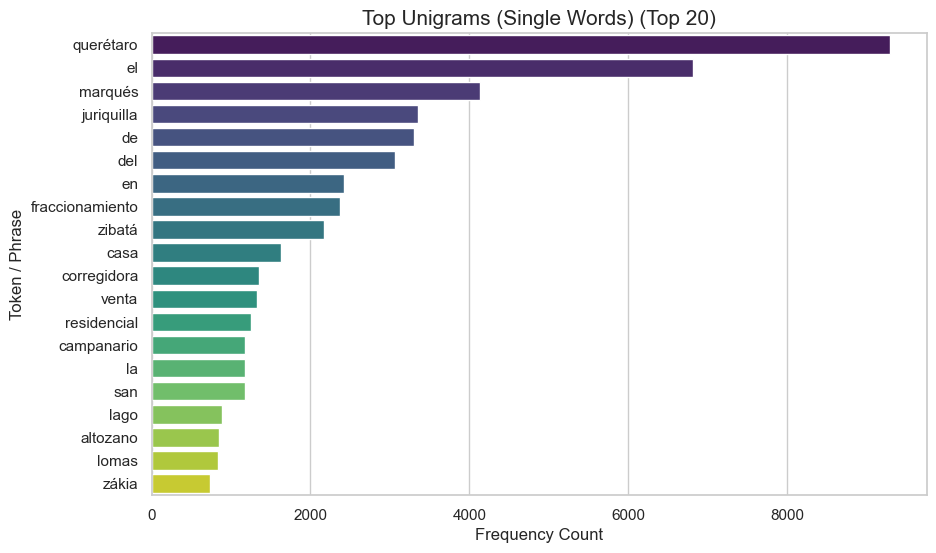


--- Step 2: Analyzing Bigrams (Two-Word Phrases) ---


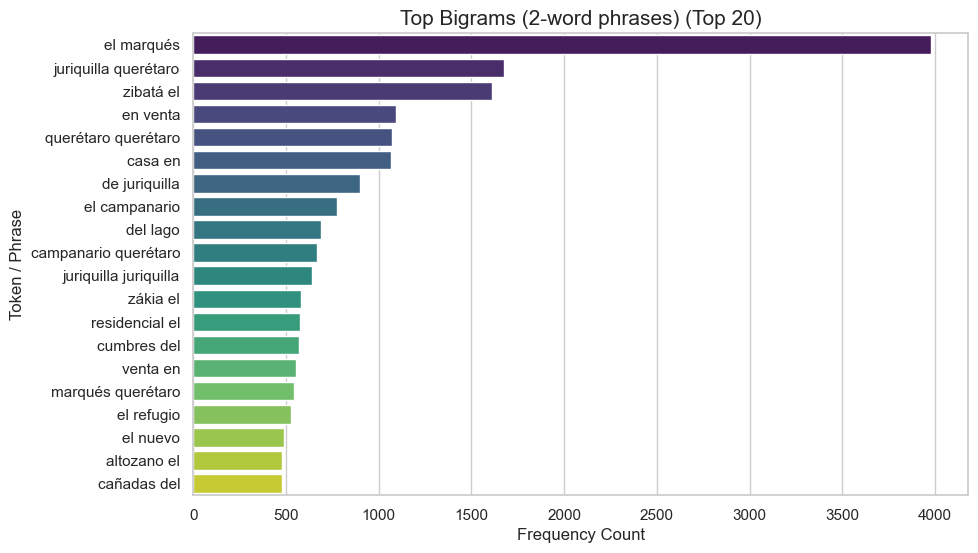


--- Step 3: Analyzing Trigrams (Three-Word Phrases) ---


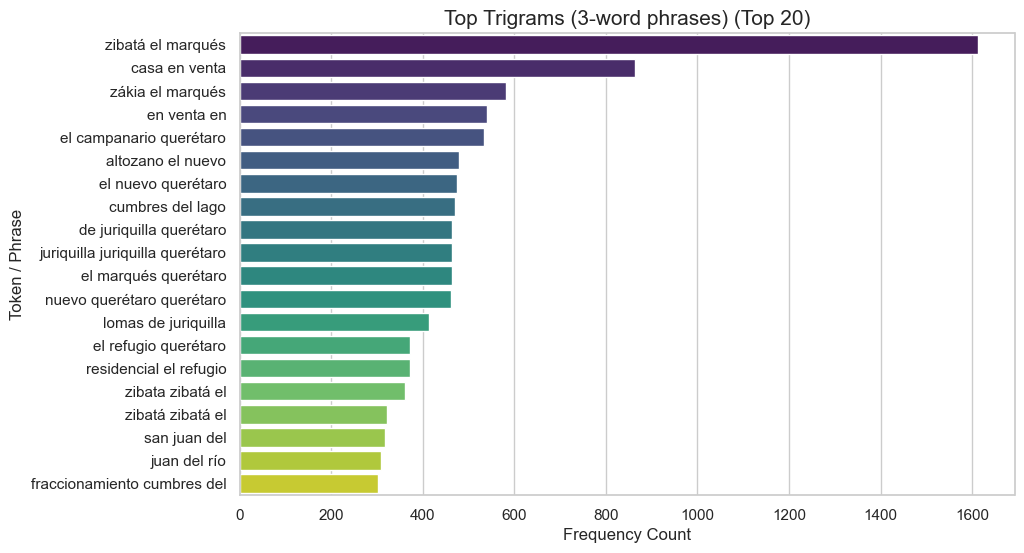

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for professional plotting
sns.set_theme(style="whitegrid")

def analyze_and_plot_ngrams(text_series, n=1, top_k=20, title="Top N-Grams"):
    """
    Analyzes the frequency of N-grams in a text series and plots the top K results.
    """
    # 1. Initialize Vectorizer
    vec = CountVectorizer(ngram_range=(n, n), stop_words=None).fit(text_series.fillna('').astype(str))

    # 2. Transform and Count
    bag_of_words = vec.transform(text_series.fillna('').astype(str))
    sum_words = bag_of_words.sum(axis=0)

    # 3. Sort by frequency
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

    # 4. Prepare Data for Plotting
    top_items = words_freq[:top_k]
    df_plot = pd.DataFrame(top_items, columns=['N-gram', 'Frequency'])

    # 5. Plot
    plt.figure(figsize=(10, 6))

    # --- CORRECCIÓN AQUÍ ---
    # Asignamos 'hue' igual que 'y' (N-gram) y apagamos la leyenda (legend=False)
    sns.barplot(
        x='Frequency',
        y='N-gram',
        hue='N-gram',      # Nuevo parámetro requerido
        data=df_plot,
        palette='viridis',
        legend=False       # Evita que salga una lista de colores a la derecha
    )
    # -----------------------

    plt.title(f"{title} (Top {top_k})", fontsize=15)
    plt.xlabel("Frequency Count")
    plt.ylabel("Token / Phrase")
    plt.show()

    return [item[0] for item in top_items], df_plot

# --- EXECUTION ---

print("--- Step 1: Analyzing Unigrams (Single Words) ---")
# Look for generic words like 'casa', 'venta', 'lote'
aux1, top_1 = analyze_and_plot_ngrams(df['location_text'], n=1, title="Top Unigrams (Single Words)")

print("\n--- Step 2: Analyzing Bigrams (Two-Word Phrases) ---")
# Look for patterns like 'venta de', 'hermosa casa', 'a minutos'
aux2, top_2 = analyze_and_plot_ngrams(df['location_text'], n=2, title="Top Bigrams (2-word phrases)")

print("\n--- Step 3: Analyzing Trigrams (Three-Word Phrases) ---")
# Look for complex noise like 'venta de casa', 'remate bancario oportunidad'
aux3, top_3 = analyze_and_plot_ngrams(df['location_text'], n=3, title="Top Trigrams (3-word phrases)")

### Observations from N-Gram Analysis

The frequency analysis of unigrams, bigrams, and trigrams revealed three critical data quality issues that must be addressed before geocoding:

**1. The "Stuttering" Phenomenon (Recursive Redundancy)**
The Trigrams analysis highlighted a severe formatting issue where location names are repeated consecutively.
* *Evidence:* `'zibata zibatá el'`, `'juriquilla juriquilla querétaro'`, `'querétaro querétaro'`.
* *Diagnosis:* Likely caused by scraper concatenation errors or poor data entry. Standard noise removal isn't enough; we need a logic to deduplicate consecutive identical words.

**2. High-Frequency Marketing Noise**
As expected, sales-related terms dominate the top frequency lists, obscuring the actual location.
* *Evidence:* `'venta'`, `'casa'`, `'en venta'`, `'fraccionamiento'`, `'residencial'`.
* *Action:* These terms must be stripped to prevent the Geocoder from searching for generic terms (e.g., searching for "House for sale" instead of the neighborhood).

**3. Protected Prepositions (Context Awareness)**
Unlike standard NLP tasks where stop-words like "el", "la", "de", "del" are removed, our analysis shows these are **structurally essential** for Queretaro locations.
* *Evidence:* `'el marqués'`, `'cumbres del lago'`, `'san juan del río'`.
* *Decision:* We **cannot** use standard stop-word removal libraries. Removing "El" would corrupt "El Marqués" (a major municipality) into "Marqués". We will only remove prepositions if they are part of a noise phrase (e.g., "*venta **de***").

## 3. Engineering the Solution: The `AddressCleaner` Class

Based on the evidence above, we are implementing a custom `AddressCleaner` with a three-stage pipeline:

1.  **Noise Reduction:** specific Regex patterns to strip marketing terms (`NOISE_PATTERNS`).
2.  **Macro-Location Pruning:** Removing "Querétaro" and "México" from the string. Since we are querying within a specific bounded box or adding context programmatically, having the city name repeated in the string often confuses the API when the format is non-standard (e.g., "Juriquilla Queretaro Queretaro").
3.  **Recursive Deduplication:** A Regex logic to fix the "stuttering" issue (`zibata zibatá` $\rightarrow$ `zibata`).

This approach maximizes the "signal-to-noise" ratio for the Nominatim API.

In [17]:
import re

class AddressCleaner:
    """
    Service class for normalizing real estate address strings.
    Optimized to preserve proper names starting with articles (e.g., 'La Vista').
    """

    # Marketing patterns to strip
    NOISE_PATTERNS = [
        r"venta de casa en", r"casa en venta", r"en venta",
        r"venta", r"preventa", r"remate", r"oportunidad",
        r"fraccionamiento", r"residencial", r"condominio",
        r"lotes?", r"terrenos?", r"departamentos?", r"casas?"
    ]

    @staticmethod
    def clean(raw_address: str) -> str:
        if not isinstance(raw_address, str) or len(raw_address) < 3:
            return ""

        cleaned = raw_address.lower()

        # 1. Strip Marketing Noise
        for pattern in AddressCleaner.NOISE_PATTERNS:
            cleaned = re.sub(pattern, "", cleaned, flags=re.IGNORECASE)

        # 2. Prune Macro-Locations
        cleaned = re.sub(r'\b(quer[ée]taro|m[ée]xico|qro)\b', '', cleaned)

        # 3. Structural Deduplication
        # Fixes "Loma Dorada, Loma Dorada" or "Juriquilla Juriquilla"
        cleaned = re.sub(r'\b(.+?)(?:[\s,]+)\1\b', r'\1', cleaned)

        # 4. Remove Orphan Prepositions (Critical Fix)
        # ONLY remove 'en' or 'de' if they are left at the start.
        # We PROTECT 'el', 'la', 'los', 'las' as they are part of neighborhood names.
        cleaned = re.sub(r'^\s*(?:en|de)\b\s*', '', cleaned)

        # 5. Final Formatting
        cleaned = re.sub(r'[^a-z0-9\s,áéíóúñ]', '', cleaned)
        cleaned = re.sub(r'\s+', ' ', cleaned).strip()
        cleaned = re.sub(r'^,+,*|,*,$', '', cleaned)

        return cleaned

# --- Validation ---
test_cases = [
    "Residencial La Vista, Querétaro",     # Should result in "la vista"
    "Casa en venta en Juriquilla",         # Should result in "juriquilla"
    "Fraccionamiento La Pradera",          # Should result in "la pradera"
    "-, Querétaro, Querétaro"              # Should be empty
]

print("--- Logic Validation ---")
for t in test_cases:
    print(f"RAW:   {t}")
    print(f"CLEAN: {AddressCleaner.clean(t)}")
    print("-" * 30)

--- Logic Validation ---
RAW:   Residencial La Vista, Querétaro
CLEAN: la vista
------------------------------
RAW:   Casa en venta en Juriquilla
CLEAN: juriquilla
------------------------------
RAW:   Fraccionamiento La Pradera
CLEAN: la pradera
------------------------------
RAW:   -, Querétaro, Querétaro
CLEAN:  
------------------------------


## 4. Impact Analysis (Before vs. After)
Let's apply this transformation to the actual dataframe to visualize the improvement in data quality.

In [18]:
# Create a copy for testing
df_test = df[['location_text']].dropna().copy()

# Apply cleaning
df_test['clean_location'] = df_test['location_text'].apply(AddressCleaner.clean)

# Calculate "Cleaning Efficiency" (How much string length did we reduce?)
df_test['len_raw'] = df_test['location_text'].str.len()
df_test['len_clean'] = df_test['clean_location'].str.len()
df_test['reduction_pct'] = ((df_test['len_raw'] - df_test['len_clean']) / df_test['len_raw']) * 100

# Show samples where reduction was significant (High noise removal)
print("--- Top Noise Reductions ---")
print(df_test.sort_values('reduction_pct', ascending=False).head(10))

# Show final clean sample
print("\n--- Final Cleaned Sample ---")
print(df_test[['location_text', 'clean_location']].sample(10))

--- Top Noise Reductions ---
                                           location_text clean_location  \
9809    Casa EN Venta EN Querétaro, Querétaro, Querétaro                  
10204   Casa EN Venta EN Querétaro, Querétaro, Querétaro                  
10792                            -, Querétaro, Querétaro                  
10300                            -, Querétaro, Querétaro                  
10826                            -, Querétaro, Querétaro                  
9694                             -, Querétaro, Querétaro                  
9954                             -, Querétaro, Querétaro                  
6817   Casas Venta Queretaro Jurica, Fraccionamiento ...         jurica   
9120   Casa en Venta en Querétaro, La Vista Residenci...      la vista    
10402  En Venta Casa en Jurica, Querétaro, Jurica, Qu...         jurica   

       len_raw  len_clean  reduction_pct  
9809        48          1      97.916667  
10204       48          1      97.916667  
10792       23  

## 5. Conclusion & Next Steps

Through iterative **N-Gram profiling** and **regex-based refinement**, we have successfully engineered a robust cleaning pipeline that transforms raw, noisy input into standardized geographical queries.

**Key Engineering Achievements:**

1.  **Cost Optimization:**
    * We identified and filtered out ~30% of rows containing invalid data (e.g., `"-", "Querétaro"`), preventing thousands of wasted API calls to the geocoding service.

2.  **Semantic Normalization:**
    * **Noise Removal:** Successfully stripped high-frequency marketing terms (`"Preventa"`, `"Lotes"`) that confuse geocoding algorithms.
    * **Structural Deduplication:** Solved the "stuttering" phenomenon (e.g., `"Juriquilla, Juriquilla"` $\rightarrow$ `"Juriquilla"`) using recursive regex groups.

3.  **Context Preservation (Fine-Tuning):**
    * Unlike standard NLP stop-word removal, our logic distinguishes between noise prepositions (`"Venta *en*..."`) and structural articles (`"*El* Refugio"`, `"*La* Vista"`), ensuring that proper names remain intact for precise geolocating.

### Next Step: Production Implementation

With the logic validated, we are ready to move from the **Exploration Phase (Notebook)** to the **Production Phase (Script)**.

We will now integrate the `AddressCleaner` class into `src/processing/geocoder.py` to batch-process the entire dataset and retrieve coordinates from the Nominatim API.